# **Алгоритм индивидуальных рекомендаций фильмов (Recommendation system)**

## **Используемые библиотеки**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import coo_matrix, csr_matrix

import optuna
import optuna.visualization as vis

from cornac.data import Dataset, FeatureModality
from cornac.eval_methods import BaseMethod
from cornac.models import ItemKNN, SVD, MF, NMF, PMF, MMMF, MTER, CTR
from cornac.metrics import MAP, NDCG, RMSE, MAE, Precision
from cornac.experiment import Experiment, Result

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

np.random.seed(17)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## **Работа с данными**

Данные содержат два файла: **movies** и **ratings**.  
  
Movies содержит информацию о более чем 62.000 фильмов. Для фильмов известны название, год выпуска и жанры.  
  
Ratings - сводная таблица рейтингов (от 0.5 до 5.0), каждому из которых соответствуют ID пользователя и фильма. Всего более 25.000.000 оценок.  

Ссылка на датасет: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system

Загрузим данные и проведем первичный анализ:

In [ ]:
movies = pd.read_csv(r"C:\Users\User\Desktop\data\recommendation\movies.csv")
ratings = pd.read_csv(r"C:\Users\User\Desktop\data\recommendation\ratings.csv")

### **Первичный аналих данных и их обработка**

In [ ]:
print(f'Количество фильмов: {movies.shape[0]}')
movies.head()

Количество фильмов: 62423


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
movies.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
movieId,62423.0,NaN,NaN,NaN,122220.387646,63264.744844,1.0,82146.5,138022.0,173222.0,209171.0
title,62423,62325,Weekend (2011),2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,62423,1639,Drama,9056,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(f'Количество рейтингов: {ratings.shape[0]}')
ratings.head()

Количество рейтингов: 25000095


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Сразу переведем колонку **timestamp** в формат **datetime**, также снизим размер данных (изменим типы на 32-битные), отсортируем рейтинги от старых к новым.  
  
В процессе выполнения проекта выяснилось, что такой объем данных требует слишком больших вычислительных мощностей, поэтому было принято решение о сокращении данных до чуть более чем 2.500.000 записей (учитываются только рейтинги начиная с 2018 года).

In [ ]:
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating'] = ratings['rating'].astype('float32')
ratings['userId'] = ratings['userId'].astype('int32')

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings = ratings[ratings['timestamp'].dt.year > 2017]

ratings = ratings.sort_values(by='timestamp')
ratings

,userId,movieId,rating,timestamp
15759507,102034,2683,2.5,2018-01-01 00:01:57
15759438,102034,1270,4.0,2018-01-01 00:02:00
15759557,102034,4022,4.0,2018-01-01 00:02:06
15759452,102034,1610,3.5,2018-01-01 00:02:08
15759479,102034,2133,2.5,2018-01-01 00:02:11
...,...,...,...,...
13207880,85523,168252,4.0,2019-11-21 09:11:19
1284508,8642,202101,2.0,2019-11-21 09:11:52
13207893,85523,204704,4.0,2019-11-21 09:12:13
1284464,8642,122914,4.0,2019-11-21 09:12:29


In [ ]:
ratings.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2511395 entries, 15759507 to 13207877
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     2511395 non-null  int32         
 1   movieId    2511395 non-null  int32         
 2   rating     2511395 non-null  float32       
 3   timestamp  2511395 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 67.1 MB


In [ ]:
ratings.describe(exclude='datetime64').T

,count,mean,std,min,25%,50%,75%,max
userId,2511395.0,80492.334370,46765.214608,3.0,39896.0,79646.0,121142.0,162536.0
movieId,2511395.0,61705.973437,63285.752414,1.0,3578.0,48516.0,106920.0,209171.0
rating,2511395.0,3.569926,1.064320,0.5,3.0,3.5,4.5,5.0


In [ ]:
for i in range(0, 6):
  print(f'Количество фильмов, у которых оценок: {i} - {len(np.where(ratings['movieId'].value_counts() == i)[0])}')

print(f'Количество фильмов, имеющих хотя бы одну оценку: {ratings.drop_duplicates('movieId').shape[0]}')

Количество фильмов, у которых оценок: 0 - 0
Количество фильмов, у которых оценок: 1 - 13720
Количество фильмов, у которых оценок: 2 - 8247
Количество фильмов, у которых оценок: 3 - 4908
Количество фильмов, у которых оценок: 4 - 3149
Количество фильмов, у которых оценок: 5 - 2274
Количество фильмов, имеющих хотя бы одну оценку: 49427


Обработаем колонки **title** и **genres** файла **movies**:  
**title** очистим от лишних символов, разделим на две колонки, отделив год от названия (получим колонки **title** и **year**);  
**genres** преобразуем в список, выведем все уникальные жанры.

In [ ]:
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [ ]:
movies['title'] = movies['title'].apply(clean_title)

title_year = movies['title'].str.rsplit(' ', n=1, expand=True)
title_year.columns = ['title', 'year']
movies.drop(columns='title', inplace=True)

movies = pd.concat([movies, title_year], axis=1)
movies = movies[['movieId', 'title', 'genres', 'year']]

In [ ]:
movies['genres'] = movies['genres'].str.split('|')
unique_genres = pd.Series([genre for genres_list in movies['genres'] for genre in genres_list]).unique()
print(f'Жанры фильмов: {(unique_genres)}')

Жанры фильмов: ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


Очистим **movies** от повторов и пропусков:

In [ ]:
movies = movies.drop_duplicates(subset='title')
movies = movies.dropna()
movies['year'].value_counts()

year
2015         2340
2016         2281
2014         2240
2017         2128
2013         2024
             ... 
Musicals        1
Trip            1
Body            1
Walter          1
Mosquitos       1
Name: count, Length: 418, dtype: int64

Заметим, что в колонке **year** для некоторых фильмов оказались слова, а не числа. Видимо, для этих фильмов год изначально не был указан, поэтому разделение произошло по словам.  
  
Удалим эти фильмы из датафрейма, а вместе с ними и просто редковстречающиеся:

In [ ]:
threshold = 7
counts = movies['year'].value_counts()
valid = counts[counts >= threshold].index

movies = movies[movies["year"].isin(valid)]

movies = movies.drop(movies.index[np.where(movies['year'] == '')])
movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
62417,209155,Santosh Subramaniam,"[Action, Comedy, Romance]",2008
62419,209159,Window of the Soul,[Documentary],2001
62420,209163,Bad Poems,"[Comedy, Drama]",2018
62421,209169,A Girl Thing,[(no genres listed)],2001


Оставим только рейтинги, относящиеся к фильмам, оставшимся в **movies**:

In [ ]:
ratings = ratings[ratings['movieId'].isin(movies['movieId'])]
print(f'Количество фильмов в ratings: {len(ratings['movieId'].value_counts())}')
print(f'Количество фильмов в movies: {movies.shape[0]}')
ratings

Количество фильмов в ratings: 45744
Количество фильмов в movies: 45744


,userId,movieId,rating,timestamp
15759507,102034,2683,2.5,2018-01-01 00:01:57
15759438,102034,1270,4.0,2018-01-01 00:02:00
15759557,102034,4022,4.0,2018-01-01 00:02:06
15759452,102034,1610,3.5,2018-01-01 00:02:08
15759479,102034,2133,2.5,2018-01-01 00:02:11
...,...,...,...,...
13207868,85523,109487,4.5,2019-11-21 09:10:45
1284508,8642,202101,2.0,2019-11-21 09:11:52
13207893,85523,204704,4.0,2019-11-21 09:12:13
1284464,8642,122914,4.0,2019-11-21 09:12:29


### **Визуализация данных**

Двадцать годов, в которые вышло наибольшее количество фильмов: 
 ['2017', '2016', '2015', '2014', '2018', '2013', '2012', '2011', '2009', '2008', '2010', '2007', '2006', '2005', '2004', '2019', '2003', '2002', '2001', '2000']
Двадцать годов, в которые вышло наименьшее количество фильмов: 
 ['1923', '1903', '1915', '1917', '1895', '1907', '1909', '1918', '1898', '1906', '1897', '1912', '1901', '1908', '1913', '1905', '1904', '1899', '1910', '1911']


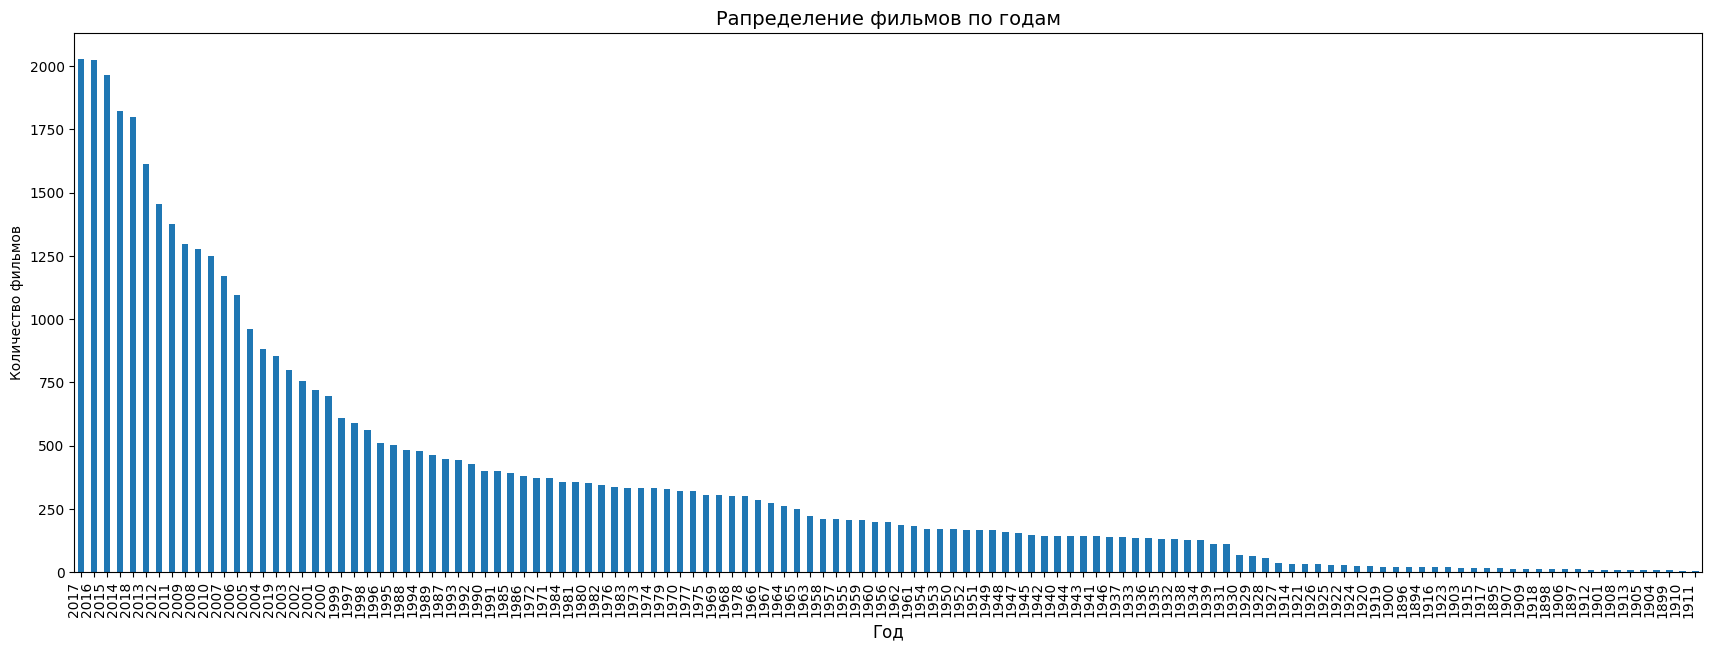

In [ ]:
genre_counts = movies['year'].value_counts()

print(f'Двадцать годов, в которые вышло наибольшее количество фильмов: \n {list(genre_counts.index[:20])}')
print(f'Двадцать годов, в которые вышло наименьшее количество фильмов: \n {list(genre_counts.index[-20:])}')

plt.figure(figsize=(18, 7))
genre_counts.plot(kind='bar')
plt.title('Рапределение фильмов по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество фильмов', fontsize=10)
plt.xticks(ha='right')
plt.show()

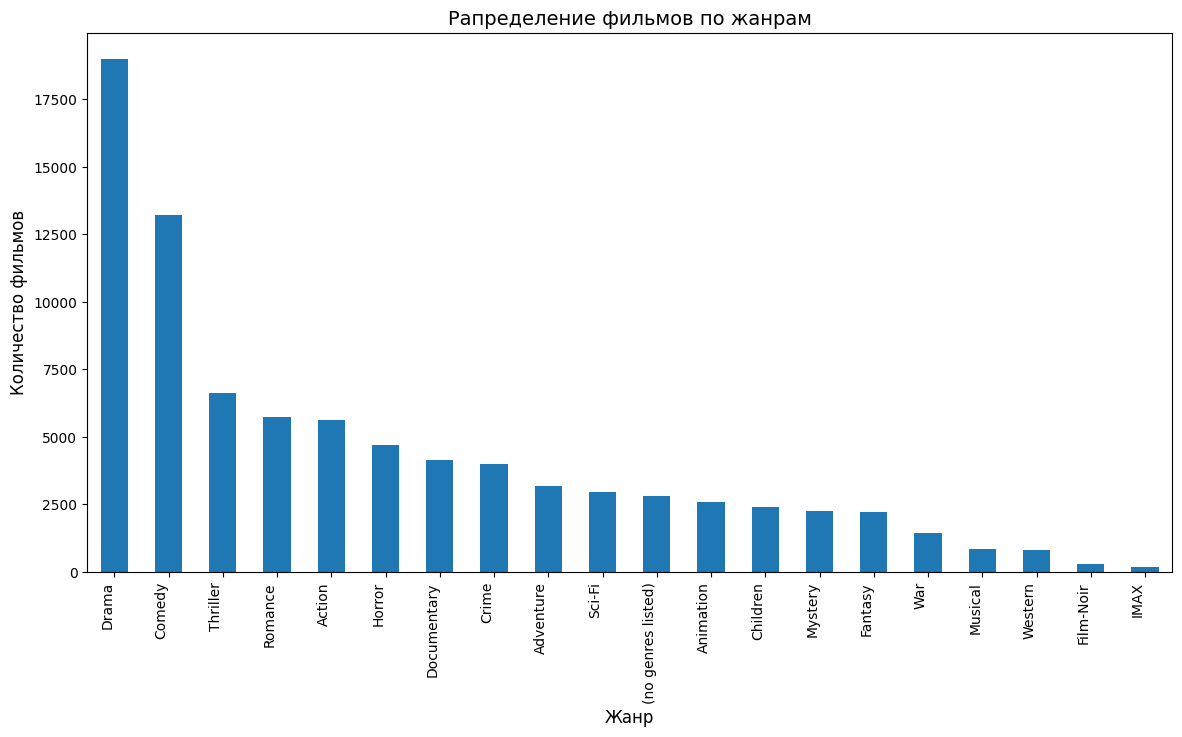

In [ ]:
genre_counts = pd.Series([genre for genres_list in movies['genres'] for genre in genres_list]).value_counts()

plt.figure(figsize=(14, 7))
genre_counts.plot(kind='bar')
plt.title('Рапределение фильмов по жанрам', fontsize=14)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Количество фильмов', fontsize=12)
plt.xticks(ha='right')
plt.show()

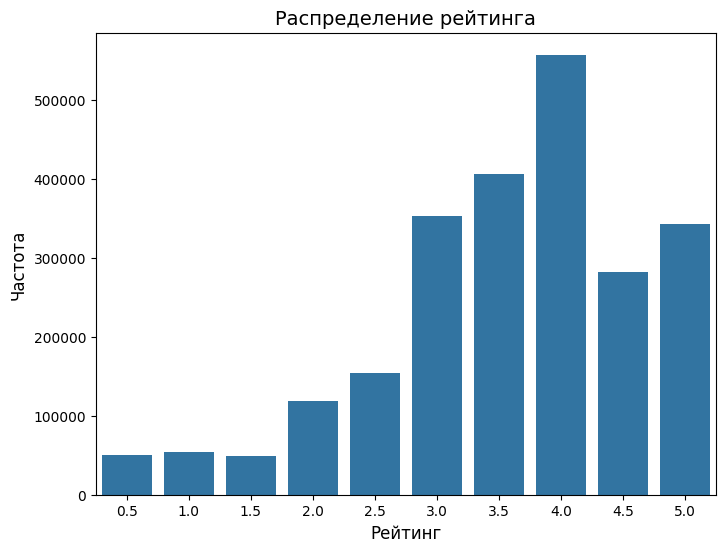

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings,
             order=sorted(ratings['rating'].unique()))
plt.title('Распределение рейтинга', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

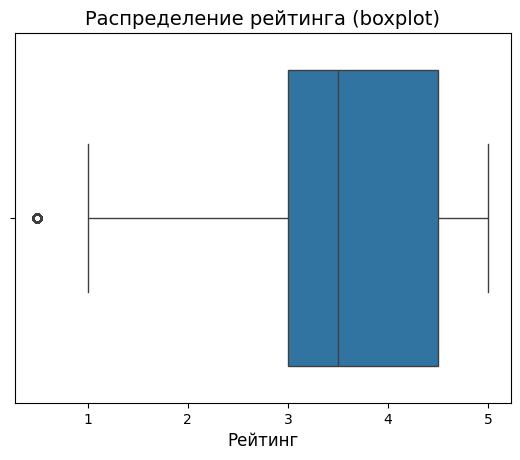

In [ ]:
sns.boxplot(x="rating", data=ratings)

plt.title('Распределение рейтинга (boxplot)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.show()

Среднее количество оценок на пользователя: 128.26786390436524


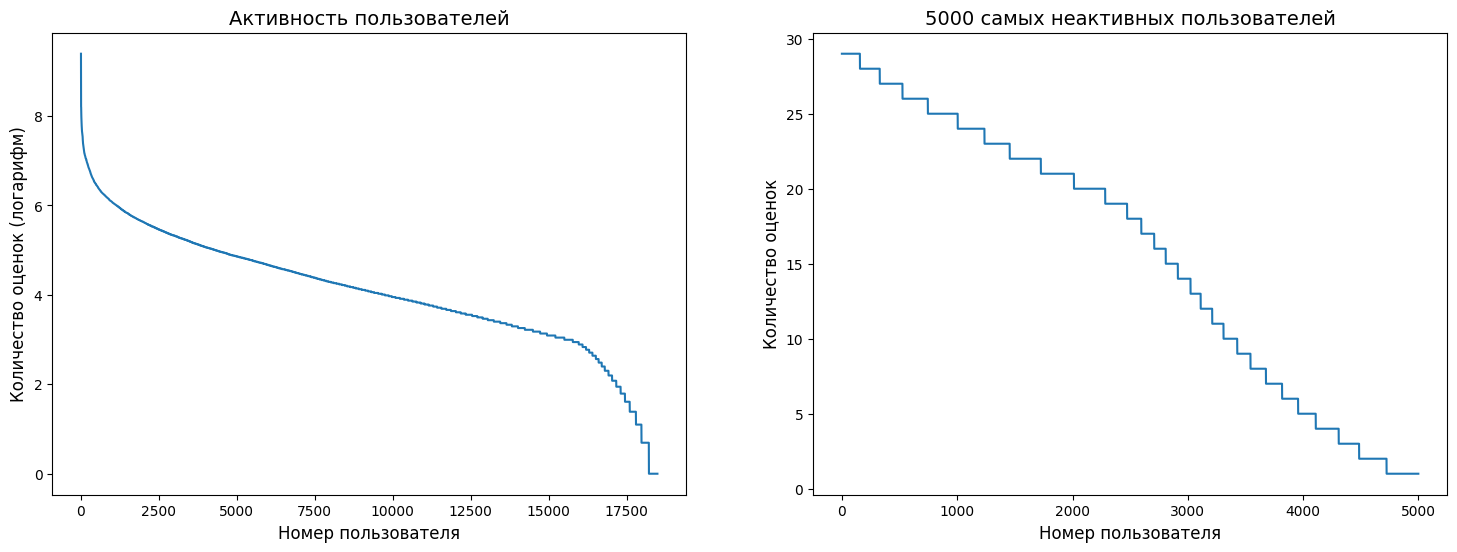

In [ ]:
print(f'Среднее количество оценок на пользователя: {np.mean(ratings['userId'].value_counts())}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

user_counts = np.log(ratings['userId'].value_counts())
user_counts.index = range(0, len(user_counts))

user_counts_min = ratings['userId'].value_counts()[-5000:]
user_counts_min.index = range(0, len(user_counts_min))

user_counts.plot(kind='line', ax=axes[0])
axes[0].set_title('Активность пользователей', fontsize=14)
axes[0].set_xlabel('Номер пользователя', fontsize=12)
axes[0].set_ylabel('Количество оценок (логарифм)', fontsize=12)

user_counts_min.plot(kind='line', ax=axes[1])
axes[1].set_title('5000 самых неактивных пользователей', fontsize=14)
axes[1].set_xlabel('Номер пользователя', fontsize=12)
axes[1].set_ylabel('Количество оценок', fontsize=12)

plt.show()

Среднее количество оценок на фильм: 51.83823015040224


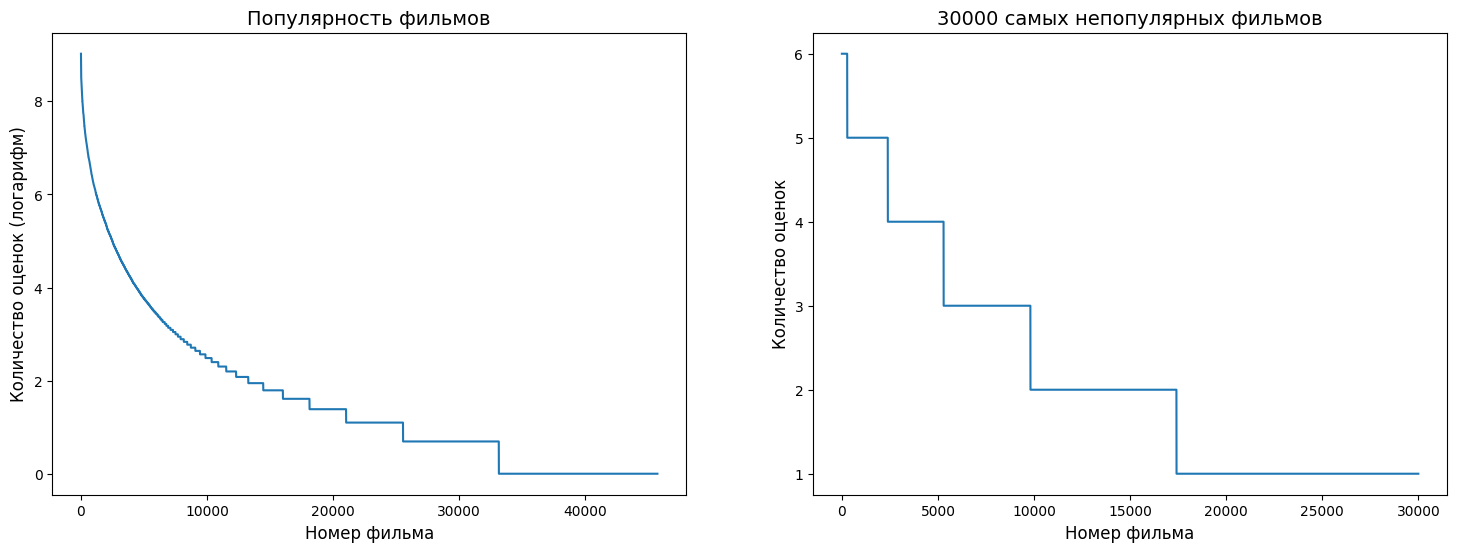

In [ ]:
print(f'Среднее количество оценок на фильм: {np.mean(ratings['movieId'].value_counts())}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

movie_counts_max = np.log(ratings['movieId'].value_counts())
movie_counts_max.index = range(0, len(movie_counts_max))

movie_counts_min = ratings['movieId'].value_counts()[-30000:]
movie_counts_min.index = range(0, len(movie_counts_min))

movie_counts_max.plot(kind='line', ax=axes[0])
axes[0].set_title('Популярность фильмов', fontsize=14)
axes[0].set_xlabel('Номер фильма', fontsize=12)
axes[0].set_ylabel('Количество оценок (логарифм)', fontsize=12)

movie_counts_min.plot(kind='line', ax=axes[1])
axes[1].set_title('30000 самых непопулярных фильмов', fontsize=14)
axes[1].set_xlabel('Номер фильма', fontsize=12)
axes[1].set_ylabel('Количество оценок', fontsize=12)

plt.show()

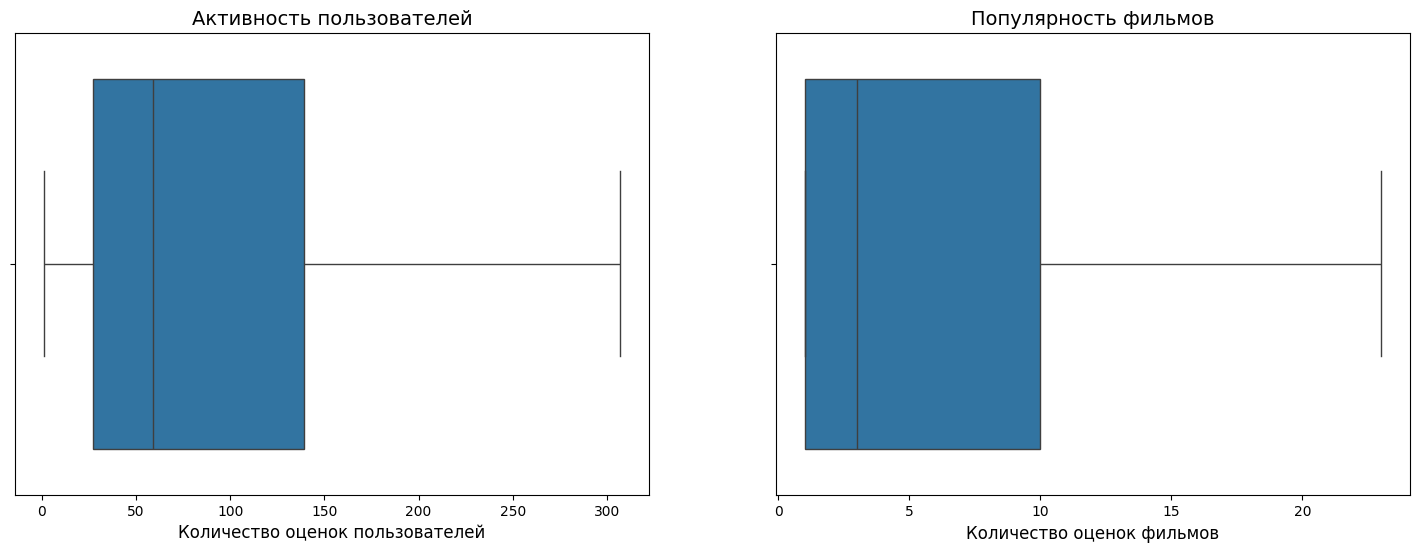

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

user_counts = ratings['userId'].value_counts()
user_counts.index = range(0, len(user_counts))

movie_counts = ratings['movieId'].value_counts()
movie_counts.index = range(0, len(movie_counts_max))

sns.boxplot(x=user_counts, showfliers=False, ax=axes[0])
axes[0].set_title('Активность пользователей', fontsize=14)
axes[0].set_xlabel('Количество оценок пользователей', fontsize=12)

sns.boxplot(x=movie_counts, showfliers=False, ax=axes[1])
axes[1].set_title('Популярность фильмов', fontsize=14)
axes[1].set_xlabel('Количество оценок фильмов', fontsize=12)

plt.show()

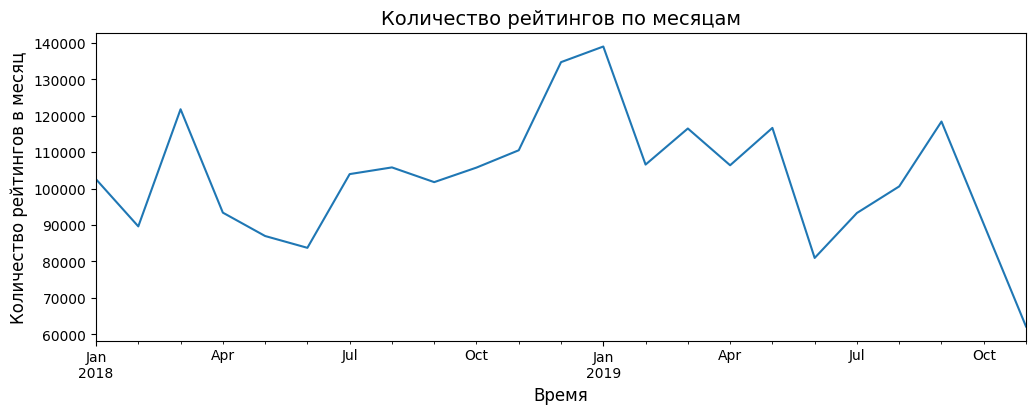

In [ ]:
df_time = ratings.set_index('timestamp').resample('ME').size()

plt.figure(figsize=(12,4))
df_time.plot()
plt.title("Количество рейтингов по месяцам", fontsize=14)
plt.ylabel("Количество рейтингов в месяц", fontsize=12)
plt.xlabel("Время", fontsize=12)
plt.show()


Удалим фильмы меньше чем с 6 оценками, а также пользователей, поставивших оценки менее 26 раз:

In [ ]:
ratings = ratings.groupby('movieId').filter(lambda count : len(count)>5)
ratings = ratings.groupby('userId').filter(lambda count : len(count)>25)

## **Подготовка данных**

Разделим данные **без перемешивания**, чтобы модели учились предсказывать будущие рейтинги на основе уже известных. Такое разбиение имитирует сценарий реальных предсказаний для пользователей.

In [ ]:
ratings_train, ratings_test = train_test_split(ratings.drop(columns='timestamp'),
                                               test_size=0.2, shuffle=False)

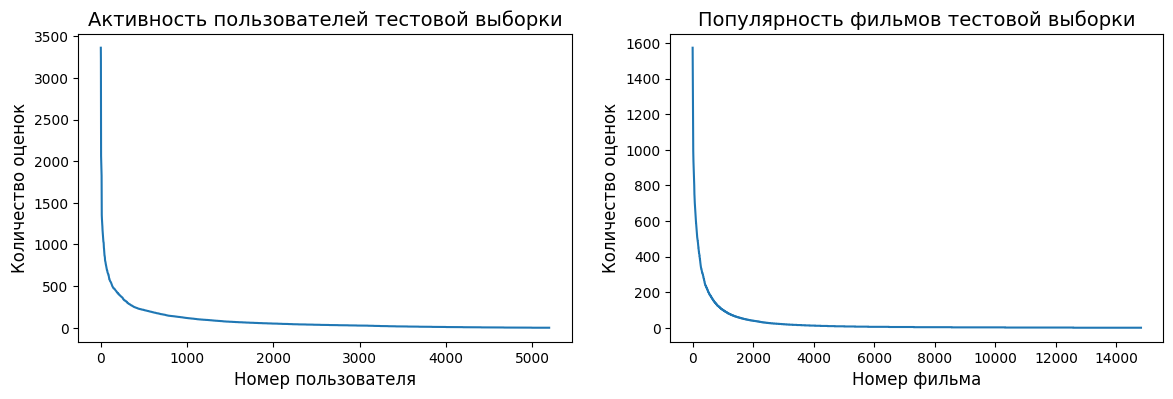

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

user_test_counts = ratings_test['userId'].value_counts()
user_test_counts.index = range(0, len(user_test_counts))

movie_test_counts = ratings_test['movieId'].value_counts()
movie_test_counts.index = range(0, len(movie_test_counts))

user_test_counts.plot(kind='line', ax=axes[0])
axes[0].set_title('Активность пользователей тестовой выборки', fontsize=14)
axes[0].set_xlabel('Номер пользователя', fontsize=12)
axes[0].set_ylabel('Количество оценок', fontsize=12)

movie_test_counts.plot(kind='line', ax=axes[1])
axes[1].set_title('Популярность фильмов тестовой выборки', fontsize=14)
axes[1].set_xlabel('Номер фильма', fontsize=12)
axes[1].set_ylabel('Количество оценок', fontsize=12)

plt.show()

## **Обучение моделей**

### **Experiment из Cornac**

Запустим Эксперимент из библиотеки **Cornac**. Это сравнительный фреймворк для мультимодальных рекомендательных систем, позволяющий быстро проводить эксперименты и легко реализовывать новые модели.  
  
В качестве моделей инициализируем **ItemKNN, Matrix Factorization, Probabilistic Matrix Factorization, SVD, Non-negative Matrix Factorization, Maximum Margin Matrix Factorization**.
  
Все методы, кроме первого, основываются на **матричной факторизации** (метод разложения большой матрицы на произведение двух или более матриц меньшего размера, чтобы выявить скрытые закономерности и латентные факторы, что позволяет предсказывать пропущенные значения и делать точные рекомендации.)

In [ ]:
evaluation = BaseMethod.from_splits(train_data=ratings_train.values,
                                        test_data=ratings_test.values,
                                        rating_threshold=4.0,
                                        exclude_unknowns=True)


models = [ItemKNN(k=20, similarity='cosine', num_threads=8), #Item-based KNN

          MF(k=50, max_iter=100, learning_rate=0.01, batch_size=256, #Matrix Factorization
             lambda_reg=0.01, use_bias=True, early_stop=True, num_threads=8),

          PMF(k=30, max_iter=100, learning_rate=0.001, gamma=0.9, #Probabilistic Matrix Factorization
              lambda_reg=0.005),

          SVD(k=50, max_iter=100, learning_rate=0.01, lambda_reg=0.01, #Matrix Factorization with biases
              early_stop=True, num_threads=8),

          NMF(k=50, max_iter=100, learning_rate=0.005, lambda_u=0.06, #Non-negative Matrix Factorization
              lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02,
              use_bias=False, num_threads=8),

          MMMF(k=50, max_iter=100, learning_rate=0.001, lambda_reg=0.01, #Maximum Margin Matrix Factorization
               num_threads=8)]

Возьмем метрики **MAP, NDCG, Precision_at_k**, которые показывают правильность ранжирования и вхождение правильных объектов в первую десятку (в нашем случае) рекоммендаций, а также **RMSE и MAE**, показывающие отклонение предсказаний оценок от истинного рейтинга:

In [ ]:
metrics = [MAP(), NDCG(k=10), Precision(k=10), RMSE(), MAE()]

In [ ]:
Experiment(eval_method=evaluation, models=models,
           metrics=metrics, user_based=True, verbose=True).run()


[ItemKNN] Training started!


  0%|          | 0/15878 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


[MF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[MF] Evaluation started!


Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


[PMF] Training started!
Learning...
epoch 0, loss: 133445.971165
epoch 1, loss: 101540.959368
epoch 2, loss: 93533.421689
epoch 3, loss: 89892.078520
epoch 4, loss: 87887.136925
epoch 5, loss: 86668.934085
epoch 6, loss: 85874.721150
epoch 7, loss: 85317.877936
epoch 8, loss: 84879.166488
epoch 9, loss: 84455.224359
epoch 10, loss: 83945.786503
epoch 11, loss: 83309.749718
epoch 12, loss: 82626.478742
epoch 13, loss: 82009.627584
epoch 14, loss: 81502.285234
epoch 15, loss: 81094.551162
epoch 16, loss: 80764.825969
epoch 17, loss: 80494.379699
epoch 18, loss: 80269.129868
epoch 19, loss: 80078.782073
epoch 20, loss: 79915.798909
epoch 21, loss: 79774.599043
epoch 22, loss: 79650.986305
epoch 23, loss: 79541.752932
epoch 24, loss: 79444.405927
epoch 25, loss: 79356.978155
epoch 26, loss: 79277.895152
epoch 27, loss: 79205.879514
epoch 28, loss: 79139.882183
epoch 29, loss: 79079.032359
epoch 30, loss: 79022.600352
epoch 31, loss: 78969.969615
epoch 32, loss: 78920.615491
epoch 33, loss

Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


[SVD] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[SVD] Evaluation started!


Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


[NMF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[NMF] Evaluation started!


Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


[MMMF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[MMMF] Evaluation started!


Rating:   0%|          | 0/81877 [00:00<?, ?it/s]

Ranking:   0%|          | 0/2931 [00:00<?, ?it/s]


TEST:
...
        |    MAE |   RMSE |    MAP | NDCG@10 | Precision@10 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------- + ------------ + --------- + --------
ItemKNN | 0.6447 | 0.7805 | 0.0060 |  0.0076 |       0.0060 |   13.5593 | 206.0473
MF      | 0.6486 | 0.7884 | 0.0070 |  0.0089 |       0.0066 |    5.1967 |   9.0575
PMF     | 0.6092 | 0.7280 | 0.0041 |  0.0023 |       0.0017 |  128.8601 |   9.1029
SVD     | 0.6510 | 0.7911 | 0.0063 |  0.0092 |       0.0076 |    5.1959 |  11.2857
NMF     | 0.6161 | 0.7509 | 0.0028 |  0.0010 |       0.0008 |   41.0060 |  10.4474
MMMF    | 3.1036 | 3.1977 | 0.0111 |  0.0135 |       0.0123 |   14.7758 |   9.4273



Из результатов Эксперимента видно, что лучший результат по метрикам ранжирования у модели **Maximum Margin Matrix Factorization**.  
  
Также эта модель показала неплохую скорость и очень большие ошибки **RMSE** и **MAE**. Это связано с тем, что данная модель в первую очередь рассчитана на ранжирование, а не на точное предсказание рейтингов.

Оптимизируем эту модель по основным параметрам по целевой метрике **Precision@K**:

In [ ]:
def objective_mf(trial):
  params = {'k' : trial.suggest_int("k", 20, 200),
            'lambda_reg' : trial.suggest_float(" lambda_reg", 1e-5, 1e-1, log=True),
            'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
            'max_iter' : trial.suggest_int("max_iter", 50, 200)}

  evaluation_search = BaseMethod.from_splits(train_data=ratings_train.values,
                                        test_data=ratings_test.values,
                                        rating_threshold=4.0,
                                        exclude_unknowns=True)
  model_search = MMMF(**params, num_threads=8)
  metric_search = [Precision(k=10)]

  results_search = evaluation_search.evaluate(model=model_search,
                                       metrics=metric_search, user_based=True)
  test_result, _ = results_search
  score_prec = test_result.metric_avg_results["Precision@10"]

  return score_prec

study_mf = optuna.create_study(direction="maximize")
study_mf.optimize(objective_mf, n_trials=100)

[I 2025-10-31 11:51:44,269] A new study created in memory with name: no-name-7c438c7a-98c7-4894-9c3e-56b1baece658
[I 2025-10-31 11:52:38,696] Trial 0 finished with value: 0.017019695280564927 and parameters: {'k': 158, ' lambda_reg': 0.0002152288958555186, 'learning_rate': 0.0019051889468136595, 'max_iter': 183}. Best is trial 0 with value: 0.017019695280564927.
[I 2025-10-31 11:52:55,862] Trial 1 finished with value: 0.026124117428465328 and parameters: {'k': 26, ' lambda_reg': 0.0013346315064486696, 'learning_rate': 0.05156325636118427, 'max_iter': 77}. Best is trial 1 with value: 0.026124117428465328.
[I 2025-10-31 11:53:19,730] Trial 2 finished with value: 0.01512448903753258 and parameters: {'k': 65, ' lambda_reg': 0.002936500408406039, 'learning_rate': 0.0003139292537485701, 'max_iter': 89}. Best is trial 1 with value: 0.026124117428465328.
[I 2025-10-31 11:53:52,977] Trial 3 finished with value: 0.015050167224080334 and parameters: {'k': 147, ' lambda_reg': 0.02408537665576781, 

/tmp/ipykernel_11/3740388091.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_mf)
/tmp/ipykernel_11/3740388091.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_mf)


Лучшие параметры модели: {'k': 30, ' lambda_reg': 1.672121977471739e-05, 'learning_rate': 0.03374121172329481, 'max_iter': 109}


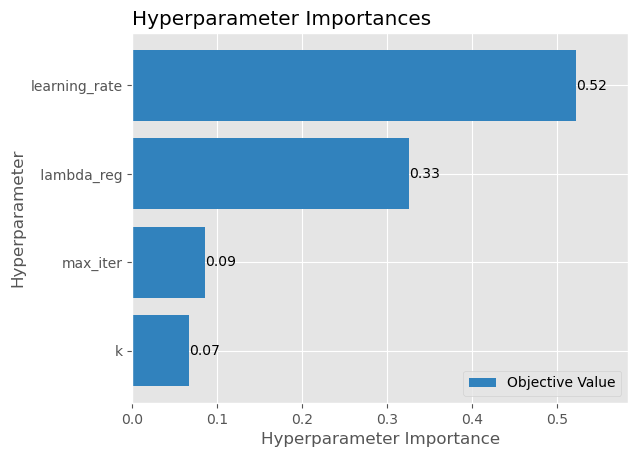

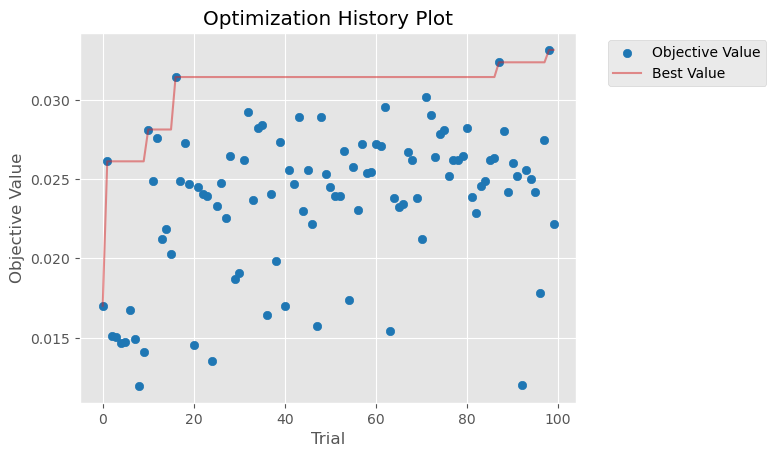

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study_mf)
optuna.visualization.matplotlib.plot_optimization_history(study_mf)
print(f'Лучшие параметры модели: {study_mf.best_params}')

В результате получим лучшие параметры для данной модели, а также самое высокое значение целевой метрики - 0.033.

### **LightFM**

Подготовим данные для модели **LightFM** (библиотека для создания рекомендательных систем, которая сочетает в себе коллаборативную фильтрацию с контентной):

In [ ]:
ratings_test = ratings_test[ratings_test['userId'].isin(ratings_train['userId']) &
                            ratings_test['movieId'].isin(ratings_train['movieId'])]

In [ ]:
dataset = Dataset()

dataset.fit(users=ratings_train['userId'].unique(),
            items=ratings_train['movieId'].unique())

(interactions_train, weights_train) = dataset.build_interactions(
    (u, i, l) for u, i, l in ratings_train[["userId", "movieId", "rating"]].values)

(interactions_test, weights_test) = dataset.build_interactions(
    (u, i, l) for u, i, l in ratings_test[["userId", "movieId", "rating"]].values)

Обучим первую модель со стандартными значениями гиперпараметров:

In [ ]:
model = LightFM(no_components=30, loss='warp')

model.fit(interactions=interactions_train,
          sample_weight=weights_train,
          epochs=50, num_threads=8, verbose=True)

Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

In [ ]:
light_fm_prec = np.mean(precision_at_k(model=model,
                                       test_interactions=interactions_test,
                                       k=10, num_threads=8))

print(f'Precision@K = {light_fm_prec}')

np.float32(0.031218015)

Подберем гиперпараметры для этой модели:

In [ ]:
def objective_lightfm(trial):
  params = {'no_components' : trial.suggest_int("no_components", 10, 200),
            'learning_schedule' : trial.suggest_categorical('learning_schedule', ['adagrad', 'adadelta']),
            'loss' : trial.suggest_categorical('loss', ['bpr', 'warp']),
            'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
            'max_sampled' : trial.suggest_int("max_sampled", 5, 50)}


  lightfm_model = LightFM(**params)

  lightfm_model.fit(interactions=interactions_train, sample_weight=weights_train,
                    epochs=10, num_threads=8)

  score = precision_at_k(model=lightfm_model,
                          test_interactions=interactions_test, k=10,
                          num_threads=8).mean()
  return score

study_lightfm = optuna.create_study(direction="maximize")
study_lightfm.optimize(objective_lightfm, n_trials=100, show_progress_bar=True)

[I 2025-10-31 09:36:20,301] A new study created in memory with name: no-name-2c2a16ef-448c-4b0b-8e7c-29c863f670b4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-31 09:36:35,303] Trial 0 finished with value: 0.020061412826180458 and parameters: {'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.00012132869066782915, 'max_sampled': 7}. Best is trial 0 with value: 0.020061412826180458.
[I 2025-10-31 09:37:15,125] Trial 1 finished with value: 0.026543842628598213 and parameters: {'no_components': 84, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.004850370954299581, 'max_sampled': 44}. Best is trial 1 with value: 0.026543842628598213.
[I 2025-10-31 09:37:25,193] Trial 2 finished with value: 0.020334357395768166 and parameters: {'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 9.893421650000455e-05, 'max_sampled': 43}. Best is trial 1 with value: 0.026543842628598213.
[I 2025-10-31 09:37:46,414] Trial 3 finished with value: 0.030092118307948112 and parameters: {'no_components': 95, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate'

/tmp/ipykernel_11/530018910.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_lightfm)
/tmp/ipykernel_11/530018910.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_lightfm)


Лучшие параметры модели: {'no_components': 151, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.025092221058238794, 'max_sampled': 40}


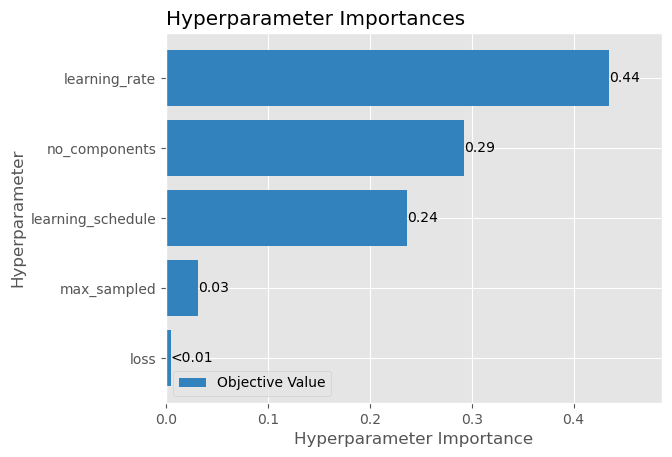

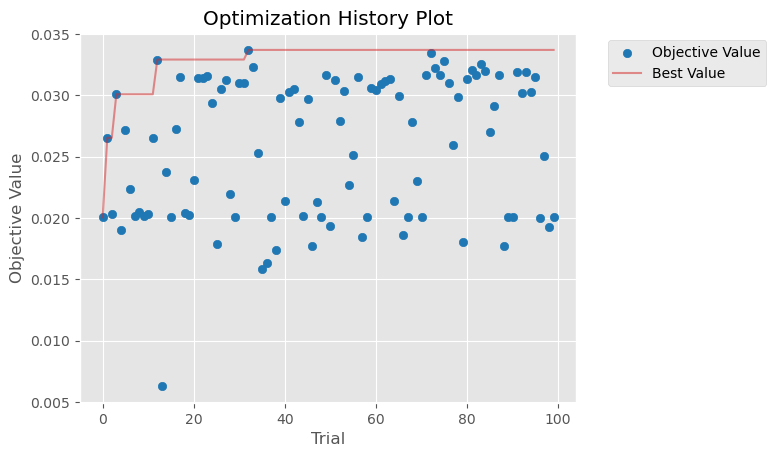

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study_lightfm)
optuna.visualization.matplotlib.plot_optimization_history(study_lightfm)
print(f'Лучшие параметры модели: {study_lightfm.best_params}')

Результат Precision@K = 0.0337.  

## **Сравнение результатов**

Сравним результаты двух оптимизированных моделей:

In [ ]:
print(f'LightFM: {study_lightfm.best_value}')
print(f'MMMF: {study_mf.best_value}')

0.03370863199234009 0.03314752879970266


В итоге модель LightFM оказалось незначительно лучше. Можно говорить об идентичных результатах

##**Дальнейшие действия**

1). Использовать данные за все года, а не только начиная с 2018 года;  
2). Использовать более продвинутые модели, основанные на глубоком обучении;  
3). Использовать контентные признаки (год выпуска фильмов, жанры и тд);  
4). Менее агрессивно фильтровать данные, оставив большее количество фильмов и оценок.  
  
Все эти действия сопряжены с использованием большого количества вычислительных ресурсов.

